In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## I. Bayesian Inference in 3 Easy Steps

#### Step 1: Specify a probability model

In [3]:
# Discrete Random Variables
from pymc3 import Poisson

x = Poisson.dist(mu=1)
samples = x.random(size=10000)

In [4]:
samples.mean(), samples.std()

(1.0166, 1.015639916505845)

(array([3663., 3605., 1894.,  630.,  163.,   39.,    6.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <BarContainer object of 7 artists>)

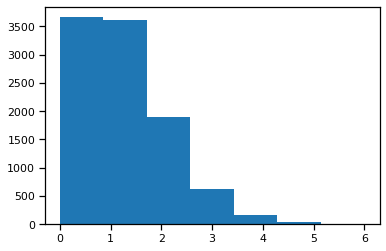

In [5]:
plt.hist(samples, bins=len(set(samples)))

In [6]:
# Continuous Random Variables
from pymc3 import Normal

y = Normal.dist(mu=-1, sd=4)
samples = y.random(size=10000)

In [7]:
samples.mean(), samples.std()

(-0.9995986371586334, 4.014998000747479)

(array([  13.,   96.,  479., 1654., 2795., 2796., 1623.,  451.,   81.,
          12.]),
 array([-16.56974208, -13.44089326, -10.31204443,  -7.18319561,
         -4.05434678,  -0.92549795,   2.20335087,   5.3321997 ,
          8.46104852,  11.58989735,  14.71874617]),
 <BarContainer object of 10 artists>)

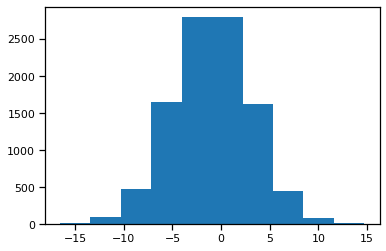

In [12]:
plt.hist(samples)

#### Step 2: Calculate a posterior distribution

#### Step 3: Check your model

## II. Estimation for one group

In [13]:
radon = pd.read_csv("data/radon.csv", index_col=0)
radon.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,5081.0,MN,MN,27.0,55735,5.0,1.0,1.0,3.0,N,...,9.7,1146.499190,1.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
1,5082.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,14.5,471.366223,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.832909
2,5083.0,MN,MN,27.0,55748,5.0,1.0,0.0,4.0,Y,...,9.6,433.316718,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,1.098612
3,5084.0,MN,MN,27.0,56469,5.0,1.0,0.0,4.0,Y,...,24.3,461.623670,0.0,0.0,1.0,AITKIN,27001.0,0.502054,0,0.095310
4,5085.0,MN,MN,27.0,55011,3.0,1.0,0.0,4.0,Y,...,13.8,433.316718,0.0,0.0,3.0,ANOKA,27003.0,0.428565,1,1.163151


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='log_radon', ylabel='Density'>

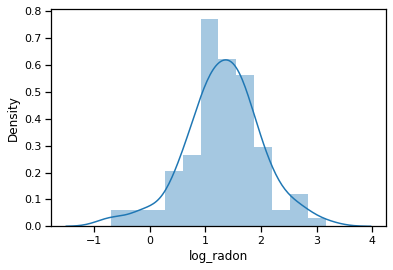

In [17]:
# Select data for one county (HENNEPIN)
hen_radon = radon.query('county=="HENNEPIN"').log_radon
sns.distplot(hen_radon)

In [18]:
# Prior model
from pymc3 import Model, Uniform

with Model() as radon_model:
    μ = Normal('μ', mu=0, sd=10)
    σ = Uniform('σ', 0, 10)    

In [20]:
with radon_model:
    y = Normal('y', mu=μ, sd=σ, observed=hen_radon)

In [25]:
from pymc3 import fit

with radon_model:
    samples = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 136.28


/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


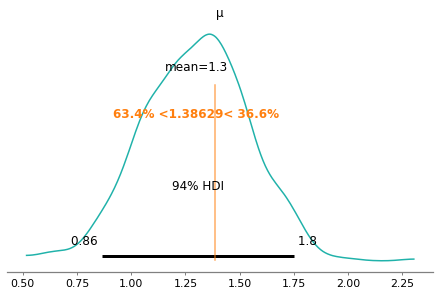

In [26]:
from pymc3 import plot_posterior

plot_posterior(samples, var_names=['μ'], ref_val=np.log(4), color='LightSeaGreen');

In [28]:
samples.__dict__

{'_straces': {0: <pymc3.backends.ndarray.NDArray at 0x7f804c50f0d0>},
 '_report': <pymc3.backends.report.SamplerReport at 0x7f804c501f40>}

#### Prediction
$$p(z |y) = \int_{\theta} p(z |\theta) p(\theta | y) d\theta$$

In [30]:
# Prediction
mus = samples['μ']
sigmas = samples['σ']
radon_samples = Normal.dist(mus, sigmas).random()

In [31]:
(radon_samples > np.log(4)).mean()

0.47

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


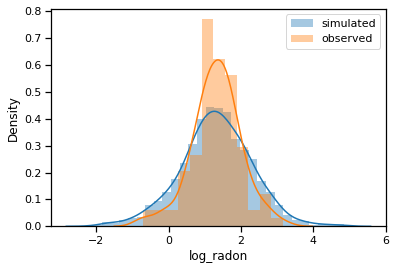

In [34]:
# Model checking
sns.distplot(radon_samples, label='simulated')
sns.distplot(hen_radon, label='observed')
plt.legend()

In [35]:
# Prior sensitivity
from pymc3 import Flat, HalfCauchy

with Model() as prior_sensitivity:
    μ = Flat('μ')
    σ = HalfCauchy('σ', 5)
    
    dist = Normal('dist', mu=μ, sd=σ, observed=hen_radon)
    sensitivity_samples = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 123.94


/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'μ'}>

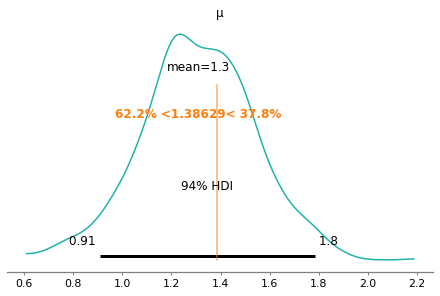

In [37]:
plot_posterior(sensitivity_samples, var_names=['μ'], ref_val=np.log(4), color='LightSeaGreen')

/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<AxesSubplot:title={'center':'μ'}>

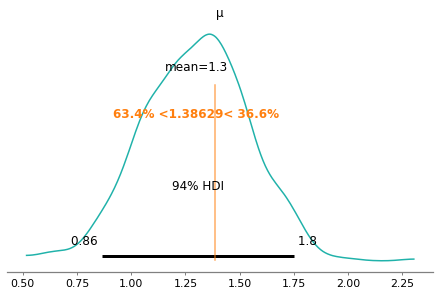

In [36]:
plot_posterior(samples, var_names=['μ'], ref_val=np.log(4), color='LightSeaGreen')

## III. Two Groups with Continiuous Outcome

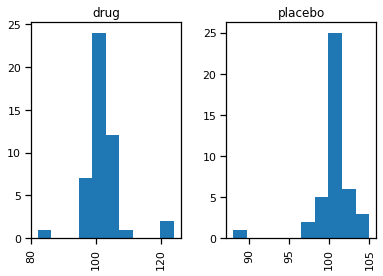

In [38]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group');

In [39]:
# Draw 10000 samples from a Student-T distribution
from pymc3 import StudentT

t = StudentT.dist(nu=3).random(size=10000)
n = Normal.dist(0, 1).random(size=10000)